## Notes

### TODO
- Collect data from multiple sensor modes

### Overview


### READ THIS BEFORE RUNNING
- Some of the following experiments depend on the PIGPIO daemon.  To activate the daemon process, execute the following command on the host machine for this notebook: "sudo pigpiod" (Note: This should be done before running the experiment cells that depend on it.)

### How to run this notebook
##### Launch jupyter notebook server on RPi
- From a local terminal session, log into the RPi on the rover
- run "source ~/.profile" to make sure virtualenvwrapper environment variables are set
- run "workon rover1" to launch the correct virtual environment
- cd to the repo root directory (nominally ~/nanibot)
- run "jupyter notebook --no-browser --port=[port #]" to launch the notebook server

##### Setup ssh tunneling and port forwarding on local machine
- run "ssh -N -f -L localhost:[port #]:localhost:[port #] pi@[RPi host IP]"
- From local browser, go to localhost:[port #]

### Implementation Details
- The implementation of the underlying periodic wakeups and serial communications were prototyped and documented in the following notebook: sandboxes/ipython_notebooks/imu_sample_rate_tests_3.ipynb
- The implementation of the syncronized Producer-Consumer, buffered data capture and signal processing where prototyped and documented in the following notebook: sandboxes/ipython_notebooks/imu_multiproc_sampling_and_buffering_test_1.ipynb

### Test Design
 
### Conclusions

### Next Steps


## Component Code

In [1]:
%matplotlib inline
from __future__ import division
import time
import sys
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
from Adafruit_BNO055 import BNO055
import serial
from serial.serialutil import SerialException

In [2]:
# -- Define some configuration constants for the imu sensor --
CALIBRATION_FILE='/home/pi/nanibot/rover1/peripherals/bno055_imu/calibration/calibration.json'
CALIBRATION_DATA=[1, 0, 2, 0, 244, 255, 223, 255, 50, 1, 210, 255, 253, 255, 255, 255, 2, 0, 232, 3, 181, 2]

BNO_AXIS_REMAP = {
        'x': BNO055.AXIS_REMAP_Y,
        'y': BNO055.AXIS_REMAP_X,
        'z': BNO055.AXIS_REMAP_Z,
        'x_sign': BNO055.AXIS_REMAP_NEGATIVE,
        'y_sign': BNO055.AXIS_REMAP_POSITIVE,
        'z_sign': BNO055.AXIS_REMAP_POSITIVE }

In [3]:
# - Add the main rover source tree to sys.path so modules are accessible - 
rover1_path = '/home/pi/nanibot/rover1'
if rover1_path not in sys.path:
    sys.path.insert(0,rover1_path)
sys.path

['/home/pi/nanibot/rover1',
 '',
 '/usr/local/lib/python2.7/dist-packages/Adafruit_BNO055-1.0.1-py2.7.egg',
 '/usr/local/lib/python2.7/dist-packages/Adafruit_GPIO-1.0.0-py2.7.egg',
 '/usr/local/lib/python2.7/dist-packages/Adafruit_PureIO-0.2.0-py2.7.egg',
 '/usr/lib/python2.7/dist-packages',
 '/usr/lib/python2.7',
 '/usr/lib/python2.7/plat-arm-linux-gnueabihf',
 '/usr/lib/python2.7/lib-tk',
 '/usr/lib/python2.7/lib-old',
 '/usr/lib/python2.7/lib-dynload',
 '/usr/local/lib/python2.7/dist-packages',
 '/usr/lib/python2.7/dist-packages/gtk-2.0',
 '/usr/lib/pymodules/python2.7',
 '/usr/local/lib/python2.7/dist-packages/IPython/extensions',
 '/home/pi/.ipython']

In [4]:
# - Override some behavior of the off the shelf Adafruit module - 
class BNO055_2(BNO055.BNO055):
    def __init__(self, rst=None, address=BNO055.BNO055_ADDRESS_A, i2c=None, gpio=None,
                 serial_port=None, serial_timeout_sec=5, baudrate=115200, 
                 max_send_attempts=5, **kwargs):
        # If reset pin is provided save it and a reference to provided GPIO
        # bus (or the default system GPIO bus if none is provided).
        self._rst = rst
        if self._rst is not None:
            if gpio is None:
                import Adafruit_GPIO as GPIO
                gpio = GPIO.get_platform_gpio()
            self._gpio = gpio
            # Setup the reset pin as an output at a high level.
            self._gpio.setup(self._rst, GPIO.OUT)
            self._gpio.set_high(self._rst)
            # Wait a 650 milliseconds in case setting the reset high reset the chip.
            time.sleep(0.65)
        self._max_send_attempts=max_send_attempts
        self._serial = None
        self._i2c_device = None
        if serial_port is not None:
            # Use serial communication if serial_port name is provided.
            # Open the serial port at 115200 baud, 8N1.  Add a 5 second timeout
            # to prevent hanging if device is disconnected.
            self._serial = serial.Serial(serial_port, baudrate, timeout=serial_timeout_sec,
                                         writeTimeout=serial_timeout_sec)
        else:
            raise AttributeError('No valid serial interface specified.')
        # - Brief pause to make sure everything finishes initializing (maybe not necessary)
        time.sleep(0.001)
        
    def _serial_send(self, command, ack=True, max_attempts=5):
        # Send a serial command and automatically handle if it needs to be resent
        # because of a bus error.  If ack is True then an ackowledgement is
        # expected and only up to the maximum specified attempts will be made
        # to get a good acknowledgement (default is 5).  If ack is False then
        # no acknowledgement is expected (like when resetting the device).
        attempts = 0
        while True:
            # Flush any pending received data to get into a clean state.
            self._serial.flushInput()
            # Send the data.
            self._serial.write(command)
            #logger.debug('Serial send: 0x{0}'.format(binascii.hexlify(command)))
            # Stop if no acknowledgment is expected.
            if not ack:
                return
            # Read acknowledgement response (2 bytes).
            resp = bytearray(self._serial.read(2))
            #logger.debug('Serial receive: 0x{0}'.format(binascii.hexlify(resp)))
            if resp is None or len(resp) != 2:
                raise RuntimeError('Timeout waiting for serial acknowledge, is the BNO055 connected?')
            # Stop if there's no bus error (0xEE07 response) and return response bytes.
            if not (resp[0] == 0xEE and resp[1] == 0x07):
                return resp
            # Else there was a bus error so resend, as recommended in UART app
            # note at:
            #   http://ae-bst.resource.bosch.com/media/products/dokumente/bno055/BST-BNO055-AN012-00.pdf
            attempts += 1
            if attempts >=  self._max_send_attempts:
                raise RuntimeError('Exceeded maximum attempts to acknowledge serial command without bus error!')

In [5]:
# - Low level helper methods for sensor sampling logic
def wakeup_handler(signum, frame):
    global wakeup_set, wakeup_wrap
    if wakeup_set:
        wakeup_wrap = True
    wakeup_set = True

def initialize_sensor_itimer(wakeup_interval_usec):
    import signal
    # Define sigaction for SIGALRM
    signal.signal(signal.SIGALRM,wakeup_handler)
    signal.setitimer(signal.ITIMER_REAL,wakeup_interval_usec*1e-6,wakeup_interval_usec*1e-6)
    
def cleanup_itimer():
    import signal
    signal.setitimer(signal.ITIMER_REAL,0,0)

def finalize_wakeup_attempt():
    global wakeup_set, wakeup_count, read_started, read_completed
    wakeup_set = False
    wakeup_count += 1
    read_started = False
    read_completed = True
    

In [6]:
# - Main runnable for sensor sampling process
def run_serial_buffer_test_4(
    num_samples, 
    sample_interval_usec, 
    max_read_retries, 
    t_array,
    x_array, 
    y_array, 
    z_array,
    buffer_offset,
    buffer_full_condition,
    buffer_mutex,
    do_axis_remap=True,
    do_calibration=False,
    qw_array=None,
    qx_array=None,
    qy_array=None,
    qz_array=None,
    heading_array=None,
    roll_array=None,
    pitch_array=None):
    
    # Reset global variables (Probably necessary for repeated runs in iPython)
    global wakeup_count, wakeup_set, read_started, read_completed, wakeup_wrap
    wakeup_count = 0
    wakeup_set = 0
    read_started = 0
    read_completed = 0
    wakeup_wrap = 0
    
    # Compute operational constants
    max_time_sec = 10 * num_samples * sample_interval_usec * 1.0e-6 # Extra factor of 10, so we don't get cutoff prematurely

    
    # -- Create serial adapter and initialize BNO055 sensor --
    imu = BNO055_2(
        serial_port='/dev/ttyAMA0', 
        rst=18, 
        baudrate=115200,
        max_send_attempts=max_read_retries)
    # -- Reset bno and set to desired mode --
    mode = BNO055.OPERATION_MODE_NDOF
    #mode = BNO055.OPERATION_MODE_AMG
    #mode = BNO055.OPERATION_MODE_GYRONLY
    
    if not imu.begin(mode=mode):
        raise RuntimeError('Failed to initialize BNO055!')
    if do_axis_remap:
        imu.set_axis_remap(**BNO_AXIS_REMAP)
    if do_calibration:
        calibration_data = CALIBRATION_DATA
        # User hardcoded calibration, rather than file
        #with open(CALIBRATION_FILE, 'r') as cal_file:
        #    calibration_data = json.load(cal_file)
        if calibration_data is not None:
            print 'Attempting BNO055 calibration'
            imu.set_calibration(calibration_data)
    
    #time.sleep(0.5)
    
    # - Repeatedly Poll Sensor until end of test
    loop_count, success_count, comm_fail_count = 0,0,0
    wrap_count, max_comm_fail_count = 0,0
    duration, heartbeat_duration = 0,0
    
    # Initialize buffer management
    buffer_size = len(t_array)
    print 'buffer_size: ',buffer_size
    
    # Initialize timers
    start_time = time.time()
    heartbeat_time = start_time
    
    try:
        # Initialize the interupt timer for periodic wakeups
        initialize_sensor_itimer(wakeup_interval_usec=sample_interval_usec)
        
        while True:
            loop_count+=1        
            if (loop_count % 100) == 0:
                current_time = time.time()
                duration = current_time - start_time
                if duration >= max_time_sec:
                    raise ValueError('Max program duration exceeded')
            if (loop_count > 100*1e6):
                raise ValueError('Max program loop count exceeded')
            if (wakeup_count > num_samples):
                raise ValueError('Max read attempts exceeded')
            
            # - Come in here if a scheduled wakeup occurred and has not been marked complete (by success or failure)
            if wakeup_set:
                # - Handle wakeup wrap condition
                if wakeup_wrap:
                    wakeup_wrap = False
                    wrap_count += 1
                    finalize_wakeup_attempt()
                    # In the case of wakeup wrap, keep wakeup_set true, but count the failed attempt
                    wakeup_set = True
                    # DEBUG
                    #print 'Wakeup wrap!'
                
                # Indicate that we have started trying to read from the sensor for the current scheduled wakeup
                read_started = 1
                read_completed = 0
        
                updated_buffer_offset = False
                # - Attempt to read linear accel (using max_read_retries)
                try:
                    # DEBUG
                    #print 'Buffer offset: ',buffer_offset.value
                    # Get lock for buffers
                    buffer_mutex.acquire()
                    # TODO: This could be improved by implementing as a FIFO that always has the "freshest possible data"
                    if buffer_offset.value < buffer_size:
                        # - First, initialize new measurements
                        t_array[buffer_offset.value] = time.time()
                        x_array[buffer_offset.value] = -99.0
                        y_array[buffer_offset.value] = -99.0
                        z_array[buffer_offset.value] = -99.0
                        if qw_array is not None:
                            qw_array[buffer_offset.value] = -99.0
                            qx_array[buffer_offset.value] = -99.0
                            qy_array[buffer_offset.value] = -99.0
                            qz_array[buffer_offset.value] = -99.0
                        if heading_array is not None:
                            heading_array[buffer_offset.value] = -400.0
                            roll_array[buffer_offset.value] = -400.0
                            pitch_array[buffer_offset.value] = -400.0
                        # - Then try to get real measurements
                        x, y, z = imu.read_linear_acceleration()
                        x_array[buffer_offset.value] = x
                        y_array[buffer_offset.value] = y
                        z_array[buffer_offset.value] = z
                        if qw_array is not None:
                            qx, qy, qz, qw = imu.read_quaternion()
                            qw_array[buffer_offset.value] = qw
                            qx_array[buffer_offset.value] = qx
                            qy_array[buffer_offset.value] = qy
                            qz_array[buffer_offset.value] = qz
                        if heading_array is not None:
                            heading, roll, pitch = imu.read_euler()
                            heading_array[buffer_offset.value] = heading
                            roll_array[buffer_offset.value] = roll
                            pitch_array[buffer_offset.value] = pitch
                        buffer_offset.value += 1
                        updated_buffer_offset = True
                        # Notify consumer that full buffer is ready to read
                        if buffer_offset.value >= buffer_size:
                            buffer_full_condition.acquire()
                            buffer_full_condition.notify()
                            buffer_full_condition.release()
                    # Release lock on buffers
                    buffer_mutex.release()
                            
                except RuntimeError as err:
                    # - increment buffer counter even upon failure
                    if read_started == 1 and not updated_buffer_offset:
                        buffer_offset.value += 1
                    print 'Runtime Exception: {}'.format(err)
                    continue
                except SerialException as err:
                    # - increment buffer counter even upon failure
                    if read_started == 1 and not updated_buffer_offset:
                        buffer_offset.value += 1
                    print 'Serial Exception: {}'.format(err)
                    print 'about to release lock in child due to exception, buffer offset: ',buffer_offset.value
                    buffer_mutex.release()
                    continue
                except:
                    # - increment buffer counter even upon failure
                    if read_started == 1 and not updated_buffer_offset:
                        buffer_offset.value += 1
                    exc_type, exc_value = sys.exc_info()[:2]
                    print 'Unknown exception on wakeup: {0}\n{1}\n{2}'.format(
                        wakeup_count,
                        exc_type,
                        exc_value)
                    print 'about to release lock in child due to exception, buffer offset: ',buffer_offset.value
                    buffer_mutex.release()
                    #raise
                    continue
                
                success_count += 1
                finalize_wakeup_attempt()
    
    except ValueError as err:
        print 'Program ended: {}'.format(err)
    except:
        exc_type, exc_value = sys.exc_info()[:2]
        print 'Unknown exception caused program to end: {0}\n{1}'.format(exc_type,exc_value)
    finally:
        cleanup_itimer()
        
    # - Cleanup after main program loop
    print 'Program duration (sec): {:0.1f}'.format(duration)
    print 'Total loop count: {}'.format(loop_count)
    print 'Read attempts: {}'.format(wakeup_count)
    print 'Sensor sample interval (ms): {:0.1f}'.format(sample_interval_usec/1000);
    print 'Successful reads: {}'.format(success_count)
    #printf("Max comm failure occurrences: %d\n",max_comm_fail_count);
    print 'Wakeup wrap count: {}'.format(wrap_count);
    print 'Read success rate: {:0.3f}'.format(success_count/wakeup_count);


## Experiments
(Continuation from http://localhost:1234/notebooks/sandboxes/ipython_notebooks/imu_multiproc_sampling_and_buffering_test_2.ipynb )

In [23]:
# - Plotting helper for several experiments
def plot_raw_and_processed_data(
    raw_data,
    filtered_data=None,
    y1lim=None,
    y2lim=None,
    y3lim=None):
    
    do_filtered_data = False
    if filtered_data is not None:
        do_filtered_data = True
    

    fig, axes = plt.subplots(figsize=(8,10),nrows=3, ncols=1)

    current_axes = axes[0]
    current_axes.plot(raw_data.x, linestyle='-', color='b', linewidth=4, alpha=0.5, label='raw')
    if do_filtered_data:
        current_axes.plot(filtered_data.x, linestyle='-', color='k', linewidth=1, alpha=1.0, label='filtered')
    current_axes.set_title('Linear Acceleration - X', fontsize=10)
    current_axes.set_ylabel('Signals', fontsize=10)
    if y1lim is not None:
        current_axes.set_ylim(y1lim)
    current_axes.legend(loc='upper left')
    current_axes.grid(which='major',axis='both')

    current_axes = axes[1]
    current_axes.plot(raw_data.y, linestyle='-', color='b', linewidth=4, alpha=0.5, label='raw')
    if do_filtered_data:
        current_axes.plot(filtered_data.y, linestyle='-', color='k', linewidth=1, alpha=1.0, label='filtered')
    current_axes.set_title('Linear Acceleration - Y', fontsize=10)
    current_axes.set_ylabel('Signals', fontsize=10)
    if y2lim is not None:
        current_axes.set_ylim(y2lim)
    current_axes.legend(loc='upper left')
    current_axes.grid(which='major',axis='both')

    current_axes = axes[2]
    current_axes.plot(raw_data.z, linestyle='-', color='b', linewidth=4, alpha=0.5, label='raw')
    if do_filtered_data:
        current_axes.plot(filtered_data.z, linestyle='-', color='k', linewidth=1, alpha=1.0, label='filtered')
    current_axes.set_title('Linear Acceleration - Z', fontsize=10)
    current_axes.set_ylabel('Signals', fontsize=10)
    if y3lim is not None:
        current_axes.set_ylim(y3lim)
    current_axes.legend(loc='upper left')
    current_axes.grid(which='major',axis='both')
    
# - Plotting helper for several experiments
def plot_euler_data(
    raw_data,
    filtered_data=None,
    y1lim=None,
    y2lim=None,
    y3lim=None):
    
    do_filtered_data = False
    if filtered_data is not None:
        do_filtered_data = True

    fig, axes = plt.subplots(figsize=(8,10),nrows=3, ncols=1)

    current_axes = axes[0]
    current_axes.plot(raw_data.heading, linestyle='-', color='b', linewidth=4, alpha=0.5, label='raw')
    if do_filtered_data:
        current_axes.plot(filtered_data.heading, linestyle='-', color='k', linewidth=1, alpha=1.0, label='filtered')
    current_axes.set_title('Heading (Degrees)', fontsize=10)
    current_axes.set_ylabel('Signals', fontsize=10)
    if y1lim is not None:
        current_axes.set_ylim(y1lim)
    current_axes.legend(loc='upper left')
    current_axes.grid(which='both',axis='both')

    current_axes = axes[1]
    current_axes.plot(raw_data.roll, linestyle='-', color='b', linewidth=4, alpha=0.5, label='raw')
    if do_filtered_data:
        current_axes.plot(filtered_data.roll, linestyle='-', color='k', linewidth=1, alpha=1.0, label='filtered')
    current_axes.set_title('Roll (Degrees)', fontsize=10)
    current_axes.set_ylabel('Signals', fontsize=10)
    if y2lim is not None:
        current_axes.set_ylim(y2lim)
    current_axes.legend(loc='upper left')
    current_axes.grid(which='both',axis='both')

    current_axes = axes[2]
    current_axes.plot(raw_data.pitch, linestyle='-', color='b', linewidth=4, alpha=0.5, label='raw')
    if do_filtered_data:
        current_axes.plot(filtered_data.pitch, linestyle='-', color='k', linewidth=1, alpha=1.0, label='filtered')
    current_axes.set_title('Pitch (Degrees)', fontsize=10)
    current_axes.set_ylabel('Signals', fontsize=10)
    if y3lim is not None:
        current_axes.set_ylim(y3lim)
    current_axes.legend(loc='upper left')
    current_axes.grid(which='both',axis='both')

In [8]:
import pandas as pd
def make_prepared_data_df(test_data,frame_ind=0):
    prepared_data = pd.DataFrame({
        't':test_data['t_data'][frame_ind],
        'x':test_data['x_data'][frame_ind],
        'y':test_data['y_data'][frame_ind],
        'z':test_data['z_data'][frame_ind]},
        index=range(len(test_data['t_data'][frame_ind])))
    if 'qw_data' in test_data.keys():
        prepared_data = prepared_data.join(
            pd.DataFrame({
                'qw':test_data['qw_data'][frame_ind],
                'qx':test_data['qx_data'][frame_ind],
                'qy':test_data['qy_data'][frame_ind],
                'qz':test_data['qz_data'][frame_ind]},
                index=range(len(test_data['t_data'][frame_ind]))),
            how='inner')
    if 'heading_data' in test_data.keys():
        prepared_data = prepared_data.join(
            pd.DataFrame({
                'heading':test_data['heading_data'][frame_ind],
                'roll':test_data['roll_data'][frame_ind],
                'pitch':test_data['pitch_data'][frame_ind]},
                index=range(len(test_data['t_data'][frame_ind]))),
            how='inner')
    return prepared_data

def log_test_data_to_file(test_data,data_file_base_name):
    # Repackage test data for writing to csv via Pandas
    prepared_data = make_prepared_data_df(test_data,frame_ind=0)
    # - Write data to file
    log_time_str = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
    prepared_data.to_csv(
        '{base_str}_{time_str}.csv'.format(base_str=data_file_base_name,time_str=log_time_str),
        index=False,
        encoding='utf-8')

### Experiment 4: 

In [50]:
# - Main runnable for motor driving process
def drive_test_1(default_speed=10,command_duration_sec=2.0,pause_between_commands_sec=0.2):
    import peripherals.sabertooth.sabertooth_adapter as sabertooth_adapter
    import components.driving.motor_control as motor_control
    
    default_command_duration = 2.0
    default_pause_duration = 0.2
    
    try:
        motorControllerAdapter = sabertooth_adapter.SabertoothPacketizedAdapterGPIO()
        motorController = motor_control.MotorController(motorControllerAdapter)
        
        start_time = time.time()
        
        motorController.goStraight()
        motorController.goForward(default_speed)
        time.sleep(min(default_command_duration,command_duration_sec))
        
        motorControllerAdapter.stop()
        time.sleep(max(default_pause_duration,pause_between_commands_sec))
        
        motorController.goStraight()
        motorController.goBackward(default_speed)
        time.sleep(min(default_command_duration,command_duration_sec))
        
        motorControllerAdapter.stop()
        
        # Increase speed 5%
        #motorController.adjustFwdBwdSetting(5)
        
    finally:
        motorControllerAdapter.stop()
        time.sleep(2)
        
def drive_test_2(
    default_speed=10.0,
    command_duration_sec=2.0,
    speed_increase_percent=10.0):
    
    import peripherals.sabertooth.sabertooth_adapter as sabertooth_adapter
    import components.driving.motor_control as motor_control
    
    max_command_duration = 2.0
    max_speed_increase_percent = 20.0
    
    try:
        motorControllerAdapter = sabertooth_adapter.SabertoothPacketizedAdapterGPIO()
        motorController = motor_control.MotorController(motorControllerAdapter)
        
        start_time = time.time()
        
        motorController.goStraight()
        motorController.goForward(default_speed)
        time.sleep(min(
                max_command_duration,
                command_duration_sec))
        
        # Increase speed by percentage
        motorController.adjustFwdBwdSetting(min(
                max_speed_increase_percent,
                speed_increase_percent))
        time.sleep(min(
                max_command_duration,
                command_duration_sec))
        
        motorControllerAdapter.stop()
        
        
    finally:
        motorControllerAdapter.stop()
        time.sleep(2)
        
def drive_test_3(
    default_speed=10.0,
    command_duration_sec=2.0,
    turn_speed=10.0,
    turn_duration_sec=2.0):
    
    import peripherals.sabertooth.sabertooth_adapter as sabertooth_adapter
    import components.driving.motor_control as motor_control
    
    max_command_duration = 5.0
    max_turn_duration = 20.0
    max_speed_increase_percent = 20.0
    
    try:
        motorControllerAdapter = sabertooth_adapter.SabertoothPacketizedAdapterGPIO()
        motorController = motor_control.MotorController(motorControllerAdapter)
        
        start_time = time.time()
        
        # Go Forward
        motorController.goStraight()
        motorController.goForward(default_speed)
        time.sleep(min(
                max_command_duration,
                command_duration_sec))
        
        # Stop
        motorControllerAdapter.stop()
        
        # Go Backward
        motorController.goStraight()
        motorController.goBackward(default_speed)
        time.sleep(min(command_duration_sec,max_command_duration))
        
        # Stop
        motorControllerAdapter.stop()
        
        # Go Right
        motorController.goRight(turn_speed)
        motorController.goForward(10) # minimal forward to allow turning
        time.sleep(min(turn_duration_sec,max_turn_duration))
        
        # Stop
        motorControllerAdapter.stop()
        
    finally:
        motorControllerAdapter.stop()
        time.sleep(2)
        
def drive_test_4(
    turn_speed=10.0,
    turn_duration_sec=2.0):
    
    import peripherals.sabertooth.sabertooth_adapter as sabertooth_adapter
    import components.driving.motor_control as motor_control
    
    max_turn_duration = 20.0
    
    try:
        motorControllerAdapter = sabertooth_adapter.SabertoothPacketizedAdapterGPIO()
        motorController = motor_control.MotorController(motorControllerAdapter)
        
        start_time = time.time()
        
        # Go Right
        motorController.goRight(turn_speed)
        motorController.goForward(15) # minimal forward to allow turning
        time.sleep(min(turn_duration_sec,max_turn_duration))
        
        # Stop
        motorControllerAdapter.stop()
        
        # Go Left
        motorController.goLeft(turn_speed)
        motorController.goForward(15) # minimal forward to allow turning
        time.sleep(min(2*turn_duration_sec,max_turn_duration))
        
        # Stop
        motorControllerAdapter.stop()
        
        # Go Right
        motorController.goRight(turn_speed)
        motorController.goForward(15) # minimal forward to allow turning
        time.sleep(min(turn_duration_sec,max_turn_duration))
        
        # Stop
        motorControllerAdapter.stop()
        
        
    finally:
        motorControllerAdapter.stop()
        time.sleep(2)

In [70]:
# - Main test script for Experiment 4
def run_simple_drive_and_sensor_read_test_4(
    buffer_size = 10,
    num_samples=100,
    sample_interval_usec=20000,
    do_axis_remap=True,
    do_calibration=False,
    drive_test_runnable=None,
    drive_test_args=None):
    
    import multiprocessing as mproc
    import time
    import math

    
    max_read_retries=5

    buffer_full_condition = mproc.Condition()
    buffer_mutex = mproc.Lock()

    t_arr = mproc.Array('d', np.zeros(buffer_size))
    x_arr = mproc.Array('d', np.zeros(buffer_size))
    y_arr = mproc.Array('d', np.zeros(buffer_size))
    z_arr = mproc.Array('d', np.zeros(buffer_size))
    qw_arr = mproc.Array('d', np.zeros(buffer_size))
    qx_arr = mproc.Array('d', np.zeros(buffer_size))
    qy_arr = mproc.Array('d', np.zeros(buffer_size))
    qz_arr = mproc.Array('d', np.zeros(buffer_size))
    qz_arr = mproc.Array('d', np.zeros(buffer_size))
    heading_arr = mproc.Array('d', np.zeros(buffer_size))
    roll_arr = mproc.Array('d', np.zeros(buffer_size))
    pitch_arr = mproc.Array('d', np.zeros(buffer_size))
    buffer_offset = mproc.Value('i',0)

    # - Define IMU Sensor Child Process
    p_sensor = mproc.Process(
        target=run_serial_buffer_test_4, 
        args=(
            num_samples,
            sample_interval_usec,
            max_read_retries,
            t_arr,x_arr,y_arr,z_arr,
            buffer_offset,
            buffer_full_condition,
            buffer_mutex,
            do_axis_remap,
            do_calibration,
            qw_arr,qx_arr,qy_arr,qz_arr,
            heading_arr,roll_arr,pitch_arr))

    # - Define Motor Controller Child Process
    if drive_test_runnable is None or drive_test_args is None:
        drive_func = drive_test_1
        drive_func_args = (
            10, # default_speed
            2, # command_duration_sec
            2) # pause_between_commands_sec
    else:
        drive_func = drive_test_runnable
        drive_func_args = drive_test_args
    p_drive = mproc.Process(
        target=drive_func, 
        args=drive_func_args) # command_duration_sec
    
    launch_start_time = time.time()
    # First start sensor process (and do a warmup wait so we don't miss the action)
    p_sensor.start()
    time.sleep(0.2)
    # Then start the motor driving process (to generate some dynamical data)
    p_drive.start()

    all_times = []
    all_x_data = []
    all_y_data = []
    all_z_data = []
    all_qw_data = []
    all_qx_data = []
    all_qy_data = []
    all_qz_data = []
    all_heading_data = []
    all_roll_data = []
    all_pitch_data = []
    # Wait for notification buffer is full
    buffer_full_condition.acquire()
    buffer_full_condition.wait(timeout=30)
    # Lock buffers from being modified while copying and resetting
    buffer_mutex.acquire()
    all_times.append([l_t - launch_start_time for l_t in t_arr[:]])
    all_x_data.append(x_arr[:])
    all_y_data.append(y_arr[:])
    all_z_data.append(z_arr[:])
    all_qw_data.append(qw_arr[:])
    all_qx_data.append(qx_arr[:])
    all_qy_data.append(qy_arr[:])
    all_qz_data.append(qz_arr[:])
    all_heading_data.append(heading_arr[:])
    all_roll_data.append(roll_arr[:])
    all_pitch_data.append(pitch_arr[:])
    buffer_offset.value = 0
    # Unlock buffers
    buffer_mutex.release()
    #time.sleep(0.01)
    buffer_full_condition.release()
    
    p_drive.join(10)
    p_sensor.join(10)

    return {
        't_data':all_times,
        'x_data':all_x_data,
        'y_data':all_y_data,
        'z_data':all_z_data,
        'qw_data':all_qw_data,
        'qx_data':all_qx_data,
        'qy_data':all_qy_data,
        'qz_data':all_qz_data,
        'heading_data':all_heading_data,
        'roll_data':all_roll_data,
        'pitch_data':all_pitch_data}

### Test 4a

In [81]:
import datetime
data_file_base_name = '/home/pi/nanibot/sandboxes/data/rover_imu_test_data_Test4a'

In [87]:
test_4a_data = run_simple_drive_and_sensor_read_test_4(
    buffer_size = 400,
    num_samples=500,
    sample_interval_usec=50000,
    do_axis_remap=True,
    do_calibration=False,
    drive_test_runnable=drive_test_4,
    drive_test_args=(
        20.0, # turn_speed
        2.0)) # turn_duration_sec

buffer_size:  400
motor command:  131   2   10   15
motor command:  131   13   77   93
motor command:  131   12   74   89
motor command:  131   0   0   3
motor command:  131   4   0   7
motor command:  131   13   50   66
motor command:  131   12   74   89
motor command:  131   0   0   3
motor command:  131   4   0   7
motor command:  131   13   77   93
motor command:  131   12   74   89
motor command:  131   0   0   3
motor command:  131   4   0   7
motor command:  131   0   0   3
motor command:  131   4   0   7
Program ended: Max read attempts exceeded
Program duration (sec): 25.0
Total loop count: 1996390
Read attempts: 501
Sensor sample interval (ms): 50.0
Successful reads: 500
Wakeup wrap count: 1
Read success rate: 0.998


In [88]:
test_data_df = make_prepared_data_df(test_4a_data,frame_ind=0)

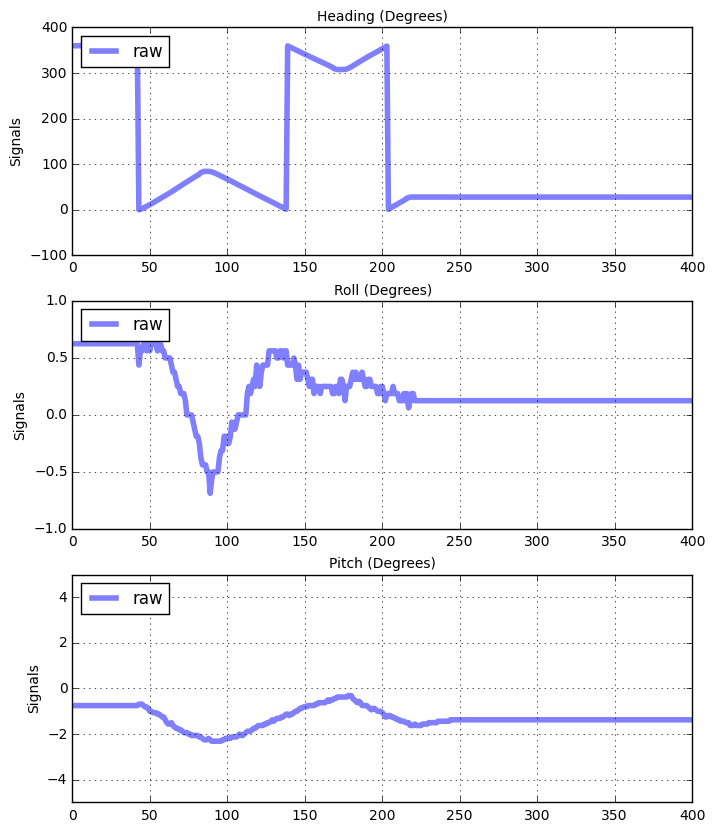

In [89]:
plot_euler_data(test_data_df,y1lim=(-100,400),y2lim=(-1,1),y3lim=(-5,5))

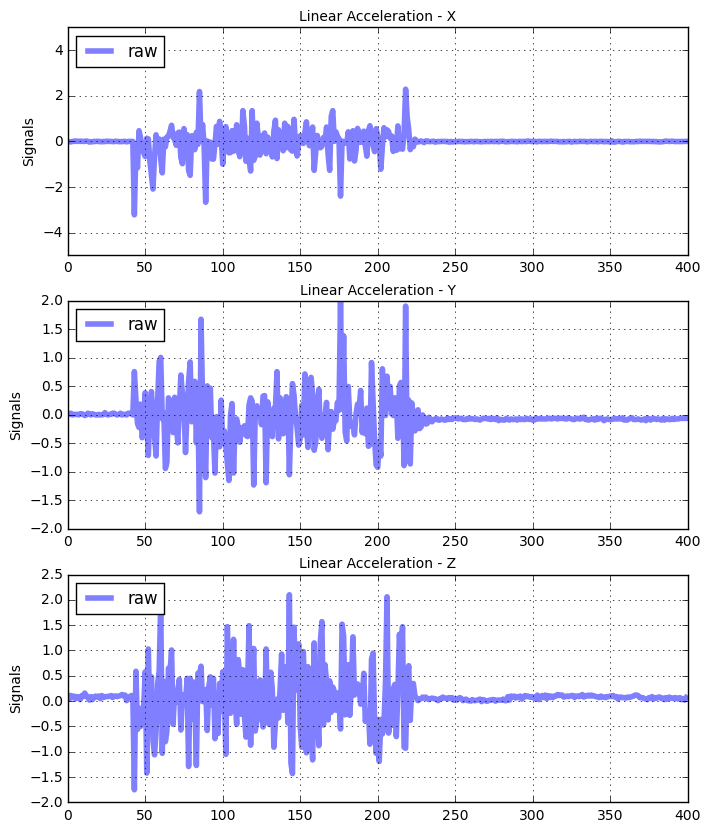

In [90]:
plot_raw_and_processed_data(test_data_df,y1lim=(-5,5))

In [91]:
log_test_data_to_file(test_4a_data,data_file_base_name)

### Test 4b

In [75]:
import datetime
data_file_base_name = '/home/pi/nanibot/sandboxes/data/rover_imu_test_data_Test4b'

In [76]:
test_4b_data = run_simple_drive_and_sensor_read_test_4(
    buffer_size = 400,
    num_samples=500,
    sample_interval_usec=50000,
    do_axis_remap=False,
    do_calibration=False,
    drive_test_runnable=drive_test_4,
    drive_test_args=(
        20.0, # turn_speed
        2.0)) # turn_duration_sec

buffer_size:  400
motor command:  131   2   10   15
motor command:  131   13   77   93
motor command:  131   12   74   89
motor command:  131   0   0   3
motor command:  131   4   0   7
motor command:  131   13   50   66
motor command:  131   12   74   89
motor command:  131   0   0   3
motor command:  131   4   0   7
motor command:  131   13   77   93
motor command:  131   12   74   89
motor command:  131   0   0   3
motor command:  131   4   0   7
motor command:  131   0   0   3
motor command:  131   4   0   7
Program ended: Max read attempts exceeded
Program duration (sec): 25.0
Total loop count: 1560984
Read attempts: 501
Sensor sample interval (ms): 50.0
Successful reads: 493
Wakeup wrap count: 8
Read success rate: 0.984


In [77]:
test_data_df = make_prepared_data_df(test_4b_data,frame_ind=0)

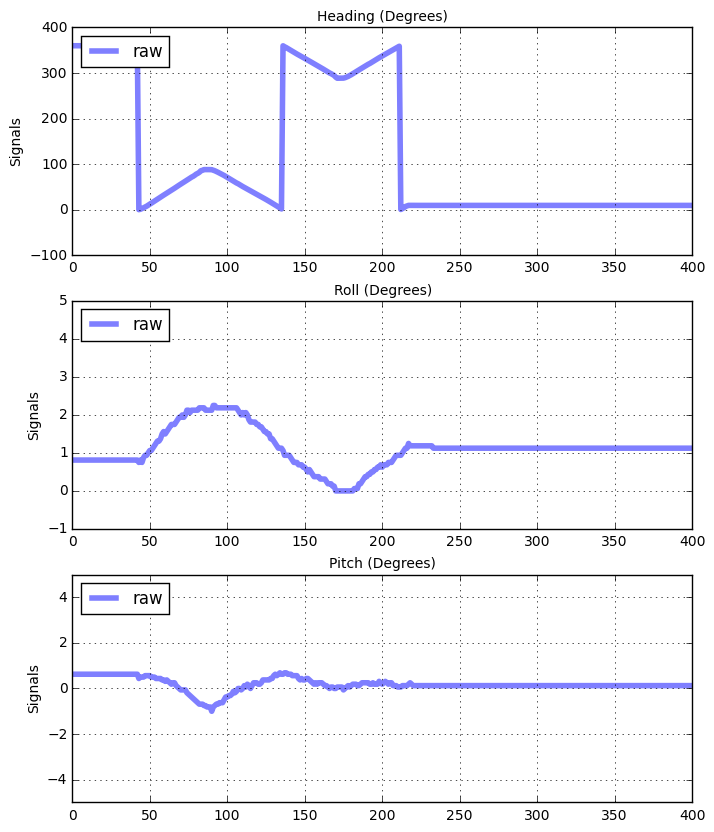

In [78]:
plot_euler_data(test_data_df,y1lim=(-100,400),y2lim=(-1,5),y3lim=(-5,5))

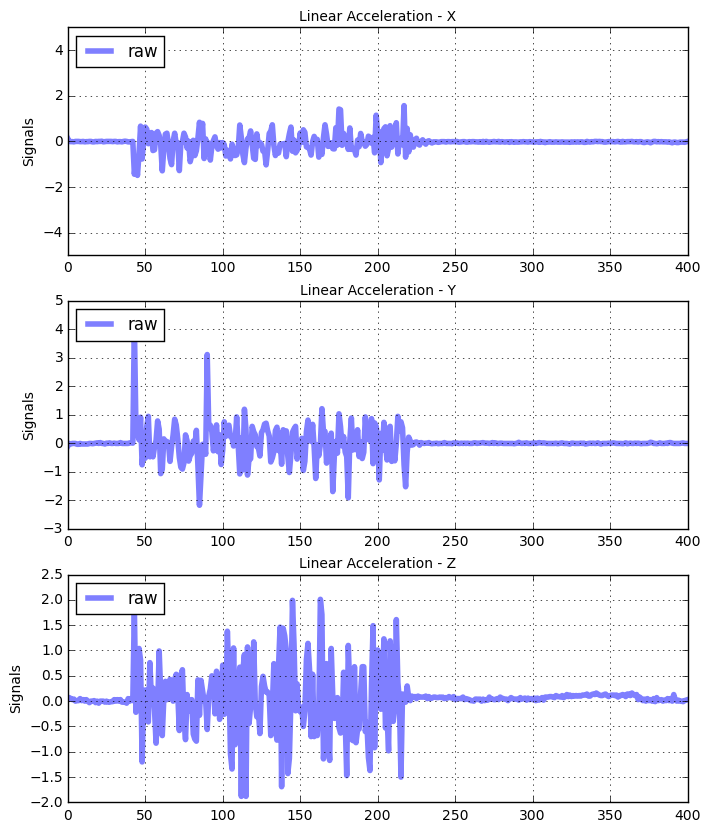

In [79]:
plot_raw_and_processed_data(test_data_df,y1lim=(-5,5))

In [80]:
log_test_data_to_file(test_4a_data,data_file_base_name)

## Sandbox

In [171]:
p.is_alive()

False

In [110]:
p.join()